In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import re
import warnings
from tqdm import tqdm
import datetime as dt

# ML/DL imports
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [3]:
def show_shapes(Sequences, Targets): # this'll use inputs; can make yours to use local variable values
    print("Expected: (num_samples, timesteps, channels)")
    print("Sequences: {}".format(Sequences.shape))
    print("Targets:   {}".format(Targets.shape))   

In [4]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [5]:
def basic_eda(df):
    print("-------------------------------TOP 5 RECORDS-----------------------------")
    print(df.head(5))
    print()
    
    print("-------------------------------INFO--------------------------------------")
    print(df.info())
    print()
    
    print("-------------------------------Describe----------------------------------")
    print(df.describe())
    print()
    
    print("-------------------------------Columns-----------------------------------")
    print(df.columns)
    print()
    
    print("-------------------------------Data Types--------------------------------")
    print(df.dtypes)
    print()
    
    print("----------------------------Missing Values-------------------------------")
    print(df.isnull().sum())
    print()
    
    print("----------------------------NULL values----------------------------------")
    print(df.isna().sum())
    print()
    
    print("--------------------------Shape Of Data---------------------------------")
    print(df.shape)
    print()
    
    print("============================================================================ \n")

In [6]:
def split_sequences(sequences, timesteps, horizon):
    Sequences, Targets = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + timesteps
        out_end_ix = end_ix + horizon-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        Sequences.append(seq_x)
        Targets.append(seq_y)
        show_shapes()
    return array(X), array(y)

In [7]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [8]:
def Normalize(list):
    list = np.array(list)
    low, high = np.percentile(list, [0, 100])
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high

def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list

def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list

In [10]:
path = '/content/drive/MyDrive/m5-forecasting'

train_data = pd.read_csv('/content/drive/MyDrive/m5-forecasting/m5-forecasting-accuracy.zip (Unzipped Files)/sales_train_validation.csv')
calendar = pd.read_csv('/content/drive/MyDrive/m5-forecasting/m5-forecasting-accuracy.zip (Unzipped Files)/calendar.csv')
sell_prices = pd.read_csv('/content/drive/MyDrive/m5-forecasting/m5-forecasting-accuracy.zip (Unzipped Files)/sell_prices.csv')
submission_file = pd.read_csv('/content/drive/MyDrive/m5-forecasting/m5-forecasting-accuracy.zip (Unzipped Files)/sample_submission.csv')

In [11]:
train_data.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30

In [12]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T, index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)

In [13]:
transfer_cal.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,...,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
event_name_1,0,0,0,0,0,0,0,0,SuperBowl,0,0,0,0,0,0,0,ValentinesDay,0,0,0,0,0,0,PresidentsDay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LentStart,0,0,0,0,0,0,LentWeek2,StPatricksDay,0,0,Purim End,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OrthodoxEaster,0,Pesach End,0,0,0,0,0,0,0,0,Cinco De Mayo,0,0,Mother's day,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MemorialDay,NBAFinalsStart,0,0,0,0,0,0,0,0,0,0,0,NBAFinalsEnd,0,0,0,0,0,0,Father's day,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IndependenceDay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ramadan starts,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Eid al-Fitr,0,0,0,0,LaborDay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Halloween,0,0,0,0,0,0,0,0,0,0,VeteransDay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Thanksgiving,0,0,0,0,0,0,0,0,0

In [14]:
event_name_1_se.head()

d_1    0.0
d_2    0.0
d_3    0.0
d_4    0.0
d_5    0.0
Name: event_name_1, dtype: float64

In [15]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date']>= '2016-2-01']  # reduce memory
calendar= transform(calendar)
# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T,
                            index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'])
transfer_cal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
event_name_1,16,16,16,16,16,16,14,16,16,2,16,16,16,15,10,16,3,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,13,16,16,16,16,16,16,11,16,16,1,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,9,8,16,16,16,0,16,16,5,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,4,16,16,7,16,16,16,16,12,16,16,16,16,16,16,16,16,16,16,16,6
event_type_1,4,4,4,4,4,4,3,4,4,2,4,4,4,0,1,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,2,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,2,4,4,4,0,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,4,4,3,4,4,4,4,2,4,4,4,4,4,4,4,4,4,4,4,3
event_name_2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
event_type_2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
snap_CA,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
snap_TX,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0
snap_WI,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0


In [16]:
price_fea = calendar[['wm_yr_wk','date']].merge(sell_prices, on = ['wm_yr_wk'], how = 'left')
price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
price_fea.head()

,wm_yr_wk,date,store_id,item_id,sell_price,id
0,11601,2016-02-01,CA_1,HOBBIES_1_001,8.26,HOBBIES_1_001_CA_1_validation
1,11601,2016-02-01,CA_1,HOBBIES_1_002,3.97,HOBBIES_1_002_CA_1_validation
2,11601,2016-02-01,CA_1,HOBBIES_1_003,2.97,HOBBIES_1_003_CA_1_validation
3,11601,2016-02-01,CA_1,HOBBIES_1_004,4.64,HOBBIES_1_004_CA_1_validation
4,11601,2016-02-01,CA_1,HOBBIES_1_005,2.88,HOBBIES_1_005_CA_1_validation


In [17]:
df = price_fea.pivot('id','date','sell_price')
df.head()

date,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_2_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_3_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_4_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,

In [18]:
price_df = train_data.merge(df,on=['id'],how= 'left').iloc[:,-140:] # -145: starts dataframe column at 2016-01-27 
price_df.index = train_data.id
price_df.head()

,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,2016-02-18 00:00:00,2016-02-19 00:00:00,2016-02-20 00:00:00,2016-02-21 00:00:00,2016-02-22 00:00:00,2016-02-23 00:00:00,2016-02-24 00:00:00,2016-02-25 00:00:00,2016-02-26 00:00:00,2016-02-27 00:00:00,2016-02-28 00:00:00,2016-02-29 00:00:00,2016-03-01 00:00:00,2016-03-02 00:00:00,2016-03-03 00:00:00,2016-03-04 00:00:00,2016-03-05 00:00:00,2016-03-06 00:00:00,2016-03-07 00:00:00,2016-03-08 00:00:00,2016-03-09 00:00:00,2016-03-10 00:00:00,2016-03-11 00:00:00,2016-03-12 00:00:00,2016-03-13 00:00:00,2016-03-14 00:00:00,2016-03-15 00:00:00,2016-03-16 00:00:00,2016-03-17 00:00:00,2016-03-18 00:00:00,2016-03-19 00:00:00,2016-03-20 00:00:00,2016-03-21 00:00:00,2016-03-22 00:00:00,2016-03-23 00:00:00,2016-03-24 00:00:00,2016-03-25 00:00:00,2016-03-26 00:00:00,2016-03-27 00:00:00,2016-03-28 00:00:00,2016-03-29 00:00:00,2016-03-30 00:00:00,2016-03-31 00:00:00,2016-04-01 00:00:00,2016-04-02 00:00:00,2016-04-03 00:00:00,2016-04-04 00:00:00,2016-04-05 00:00:00,2016-04-06 00:00:00,2016-04-07 00:00:00,2016-04-08 00:00:00,2016-04-09 00:00:00,2016-04-10 00:00:00,2016-04-11 00:00:00,2016-04-12 00:00:00,2016-04-13 00:00:00,2016-04-14 00:00:00,2016-04-15 00:00:00,2016-04-16 00:00:00,2016-04-17 00:00:00,2016-04-18 00:00:00,2016-04-19 00:00:00,2016-04-20 00:00:00,2016-04-21 00:00:00,2016-04-22 00:00:00,2016-04-23 00:00:00,2016-04-24 00:00:00,2016-04-25 00:00:00,2016-04-26 00:00:00,2016-04-27 00:00:00,2016-04-28 00:00:00,2016-04-29 00:00:00,2016-04-30 00:00:00,2016-05-01 00:00:00,2016-05-02 00:00:00,2016-05-03 00:00:00,2016-05-04 00:00:00,2016-05-05 00:00:00,2016-05-06 00:00:00,2016-05-07 00:00:00,2016-05-08 00:00:00,2016-05-09 00:00:00,2016-05-10 00:00:00,2016-05-11 00:00:00,2016-05-12 00:00:00,2016-05-13 00:00:00,2016-05-14 00:00:00,2016-05-15 00:00:00,2016-05-16 00:00:00,2016-05-17 00:00:00,2016-05-18 00:00:00,2016-05-19 00:00:00,2016-05-20 00:00:00,2016-05-21 00:00:00,2016-05-22 00:00:00,2016-05-23 00:00:00,2016-05-24 00:00:00,2016-05-25 00:00:00,2016-05-26 00:00:00,2016-05-27 00:00:00,2016-05-28 00:00:00,2016-05-29 00:00:00,2016-05-30 00:00:00,2016-05-31 00:00:00,2016-06-01 00:00:00,2016-06-02 00:00:00,2016-06-03 00:00:00,2016-06-04 00:00:00,2016-06-05 00:00:00,2016-06-06 00:00:00,2016-06-07 00:00:00,2016-06-08 00:00:00,2016-06-09 00:00:00,2016-06-10 00:00:00,2016-06-11 00:00:00,2016-06-12 00:00:00,2016-06-13 00:00:00,2016-06-14 00:00:00,2016-06-15 00:00:00,2016-06-16 00:00:00,2016-06-17 00:00:00,2016-06-18 00:00:00,2016-06-19 00:00:00
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
HOBBIES_1_002_CA_1_validation,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [20]:
train_data = downcast_dtypes(train_data)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1913), object(6)
memory usage: 112.6+ MB


In [21]:
train_data = train_data.iloc[:, -140:]
train_data.head(10)

,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,0,0,1,1,0,2,0,1,0,2,1,1,5,0,1,0,3,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,3,1,1,4,3,2,1,2,2,0,1,5,2,0,1,2,3,0,1,2,1,3,0,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,0,0,1,1,0,2,2,2,3,2,1,2,0,5,0,1,0,0,0,3,4,0,0,1,5,3,2,2,0,1,1,0,2,1,0,2,4,0,0,0,3,2,4,3,1,2,3,0,8,2,1,2,2,5,2,6,1,0,3,5,1,1,6,4,3,2,2,3,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,1,2,1,2,1,2,3,3,0,3,1,5,3,2,1,2,3,4,0,0,1,0,0,1,0,0,1,0,0,0,0,2,0,0,3,0,0,1,2,2,0,1,0,0,0,1,0,0,3,0,0,1,1,0,3,1,0,4,1,2,0,0,0,1,1,2,0,0,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
5,1,0,1,2,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,3,4,0,0,0,8,0,2,0,1,0,0,1,0,3,0,0,0,1,3,0,0,1,0,0,3,3,0,0,0,0,3,0,2,2,1,0,0,0,0,9,1,0,0,0,0,1,0,2,1,3,0,0,0,1,3,0,4,0,0,0,1,5,0,1,0,0,2,0,3,1,1,2,0,1,3,0,0,0,0,0,0,3,0,1,0,0,1,4,0,0,0,1,0,1,0,0,0,2,0,0
6,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,2,1,0,0,0,0,0,0,0,0,1,1,0,0,0,2,2,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,2,1,0,0,1,0,2,0,0,1,0,0,1,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1
7,20,12,7,27,49,0,0,7,0,6,5,11,25,0,8,19,5,9,0,17,0,7,2,9,7,7,30,7,2,1,2,75,8,15,1,17,5,8,18,6,47,5,48,4,16,13,13,14,4,3,0,8,1,1,23,12,4,5,44,32,9,37,0,5,18,4,0,7,27,23,1,9,2,24,11,10,11,34,0,10,4,12,17,0,0,0,0,0,0,0,0,0,4,27,1,2,19,28,3,1,2,0,17,11,0,2,13,10,2,0,0,0,0,11,5,2,12,38,22,2,0,10,26,8,12,4,5,2,8,4,0,0,1,37,3,4,6,3,2,1
8,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2,0,3,0,0,0,0,0,1,1,0,7,0,0,0,0,1,1,6,0,0,0,0,0
9,1,0,0,0,1,0,1,1,0,1,0,0,3,1,0,0,0,1,0,0,3,0,2,0,0,1,0,1,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,4,0,0,1,1,1,2,1,1,0,0,0,1,1,1,0,1,3,0,0,0,0,1,1,1,2,0,0,0,0,1,2,0,2,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,2,3,0,0,0,0,0,0,0,0,1,1,1,1,0,3,2,2,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0,2


In [22]:
time_series_col1 = train_data.columns
time_series_col2 = price_df.columns
time_series_col3 = transfer_cal.columns

print(len(time_series_col1),len(time_series_col2),len(time_series_col3))

140 140 140


In [23]:
price_df.columns = time_series_col1
transfer_cal.columns = time_series_col1

train_data.shape, price_df.shape, transfer_cal.shape

((30490, 140), (30490, 140), (7, 140))

In [24]:
full_train_data = pd.concat([train_data, transfer_cal, price_df], axis=0)
full_train_data.tail(10)

,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
FOODS_3_818_WI_3_validation,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98
FOODS_3_819_WI_3_validation,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98
FOODS_3_820_WI_3_validation,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98
FOODS_3_821_WI_3_validation,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98,4.98
FOODS_3_822_WI_3_validation,4.48,4.48,4.48,4.48,4.48,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98

In [25]:
# Litle bit of exploration of data
print("=================================train_data=================================")
basic_eda(full_train_data)

=================================train_data=================================
-------------------------------TOP 5 RECORDS-----------------------------
   d_1774  d_1775  d_1776  d_1777  d_1778  d_1779  d_1780  d_1781  d_1782  \
0     1.0     2.0     1.0     0.0     0.0     0.0     0.0     0.0     1.0   
1     0.0     0.0     1.0     1.0     0.0     2.0     0.0     1.0     0.0   
2     2.0     3.0     1.0     1.0     4.0     3.0     2.0     1.0     2.0   
3     0.0     0.0     1.0     1.0     0.0     2.0     2.0     2.0     3.0   
4     1.0     2.0     1.0     2.0     1.0     2.0     3.0     3.0     0.0   

   d_1783  d_1784  d_1785  d_1786  d_1787  d_1788  d_1789  d_1790  d_1791  \
0     0.0     3.0     0.0     1.0     2.0     1.0     0.0     3.0     0.0   
1     2.0     1.0     1.0     5.0     0.0     1.0     0.0     3.0     5.0   
2     2.0     0.0     1.0     5.0     2.0     0.0     1.0     2.0     3.0   
3     2.0     1.0     2.0     0.0     5.0     0.0     1.0     0.0     0.0   
4

In [26]:
full_train_data.fillna(method='backfill', axis=1, inplace=True)
np.sum(full_train_data.isnull().sum())

0

In [27]:
full_train_data_transposed = full_train_data.T
full_train_data_transposed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,FOODS_3_575_WI_3_validation,FOODS_3_576_WI_3_validation,FOODS_3_577_WI_3_validation,FOODS_3_578_WI_3_validation,FOODS_3_579_WI_3_validation,FOODS_3_580_WI_3_validation,FOODS_3_581_WI_3_validation,FOODS_3_582_WI_3_validation,FOODS_3_583_WI_3_validation,FOODS_3_584_WI_3_validation,FOODS_3_585_WI_3_validation,FOODS_3_586_WI_3_validation,FOODS_3_587_WI_3_validation,FOODS_3_588_WI_3_validation,FOODS_3_589_WI_3_validation,FOODS_3_590_WI_3_validation,FOODS_3_591_WI_3_validation,FOODS_3_592_WI_3_validation,FOODS_3_593_WI_3_validation,FOODS_3_594_WI_3_validation,FOODS_3_595_WI_3_validation,FOODS_3_596_WI_3_validation,FOODS_3_597_WI_3_validation,FOODS_3_598_WI_3_validation,FOODS_3_599_WI_3_validation,FOODS_3_600_WI_3_validation,FOODS_3_601_WI_3_validation,FOODS_3_602_WI_3_validation,FOODS_3_603_WI_3_validation,FOODS_3_604_WI_3_validation,FOODS_3_605_WI_3_validation,FOODS_3_606_WI_3_validation,FOODS_3_607_WI_3_validation,FOODS_3_608_WI_3_validation,FOODS_3_609_WI_3_validation,FOODS_3_610_WI_3_validation,FOODS_3_611_WI_3_validation,FOODS_3_612_WI_3_validation,FOODS_3_613_WI_3_validation,FOODS_3_614_WI_3_validation,FOODS_3_615_WI_3_validation,FOODS_3_616_WI_3_validation,FOODS_3_617_WI_3_validation,FOODS_3_618_WI_3_validation,FOODS_3_619_WI_3_validation,FOODS_3_620_WI_3_validation,FOODS_3_621_WI_3_validation,FOODS_3_622_WI_3_validation,FOODS_3_623_WI_3_validation,FOODS_3_624_WI_3_validation,FOODS_3_625_WI_3_validation,FOODS_3_626_WI_3_validation,FOODS_3_627_WI_3_validation,FOODS_3_628_WI_3_validation,FOODS_3_629_WI_3_validation,FOODS_3_630_WI_3_validation,FOODS_3_631_WI_3_validation,FOODS_3_632_WI_3_validation,FOODS_3_633_WI_3_validation,FOODS_3_634_WI_3_validation,FOODS_3_635_WI_3_validation,FOODS_3_636_WI_3_validation,FOODS_3_637_WI_3_validation,FOODS_3_638_WI_3_validation,FOODS_3_639_WI_3_validation,FOODS_3_640_WI_3_validation,FOODS_3_641_WI_3_validation,FOODS_3_642_WI_3_validation,FOODS_3_643_WI_3_validation,FOODS_3_644_WI_3_validation,FOODS_3_645_WI_3_validation,FOODS_3_646_WI_3_validation,FOODS_3_647_WI_3_validation,FOODS_3_648_WI_3_validation,FOODS_3_649_WI_3_validation,FOODS_3_650_WI_3_validation,FOODS_3_651_WI_3_validation,FOODS_3_652_WI_3_validation,FOODS_3_653_WI_3_validation,FOODS_3_654_WI_3_validation,FOODS_3_655_WI_3_validation,FOODS_3_656_WI_3_validation,FOODS_3_657_WI_3_validation,FOODS_3_658_WI_3_validation,FOODS_3_659_WI_3_validation,FOODS_3_660_WI_3_validation,FOODS_3_661_WI_3_validation,FOODS_3_662_WI_3_validation,FOODS_3_663_WI_3_validation,FOODS_3_664_WI_3_validation,FOODS_3_665_WI_3_validation,FOODS_3_666_WI_3_validation,FOODS_3_667_WI_3_validation,FOODS_3_668_WI_3_validation,FOODS_3_669_WI_3_validation,FOODS_3_670_WI_3_validation,FOODS_3_671_WI_3_validation,FOODS_3_672_WI_3_validation,FOODS_3_673_WI_3_validation,FOODS_3_674_WI_3_validation,FOODS_3_675_WI_3_validation,FOODS_3_676_WI_3_validation,FOODS_3_677_WI_3_validation,FOODS_3_678_WI_3_validation,FOODS_3_679_WI_3_validation,FOODS_3_680_WI_3_validation,FOODS_3_681_WI_3_validation,FOODS_3_682_WI_3_validation,FOODS_3_683_WI_3_validation,FOODS_3_684_WI_3_validation,FOODS_3_685_WI_3_validati

In [28]:
object_cols = [cname for cname in full_train_data_transposed.columns 
               if full_train_data_transposed[cname].dtype == "object" 
               and cname != "date"]

print("Categorical Columns:")
len(object_cols)

Categorical Columns:


0

In [29]:
num_cols = [cname for cname in full_train_data_transposed.columns 
            if full_train_data_transposed[cname].dtype in ['int64', 'float64', 'int16', 'float32']
            and cname not in ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']]

print("Numerical Columns:")
len(num_cols)

Numerical Columns:


60980

In [30]:
all_cols = num_cols + object_cols
print("All Columns:")
len(all_cols)

All Columns:


60980

In [31]:
timesteps = 28
horizon = 28

full_train_data_sequenced = []   

for i in tqdm(range(train_data.shape[0])):      # Using tqdm to visualize the progress

    full_train_data_sequenced.append([list(t) for t in zip(full_train_data_transposed['event_name_1'][-(100+14):-(14)],
                                       full_train_data_transposed['event_type_1'][-(100+14):-(14)],
                                       full_train_data_transposed['event_name_2'][-(100+14):-(14)],     
                                       full_train_data_transposed['event_type_2'][-(100+14):-(14)],
                                       full_train_data_transposed['snap_CA'][-(100+14):-(14)],
                                       full_train_data_transposed['snap_TX'][-(100+14):-(14)],
                                       full_train_data_transposed['snap_WI'][-(100+14):-(14)],
                                       price_df.iloc[i][-100:],
                                       train_data.iloc[i][-100:])]) 

full_train_data_sequenced = np.asarray(full_train_data_sequenced, dtype=np.float32)

100%|██████████| 30490/30490 [00:40<00:00, 760.65it/s]


In [32]:
norm_full_train_data, train_low, train_high = Normalize(full_train_data_sequenced[:,-(timesteps*2):,:])

In [33]:
print(norm_full_train_data.shape)
print(train_low)
print(train_high)

(30490, 56, 9)
0.0
248.0


In [34]:
num_features = 9

X_train = norm_full_train_data[:,-28*2:-28,:]
y_train = norm_full_train_data[:,-28:,8] 

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

show_shapes(X_train, y_train)

Expected: (num_samples, timesteps, channels)
Sequences: (30490, 28, 9)
Targets:   (30490, 28, 1)


In [35]:
def encoder_decoder_model():
    
    # Use Keras sequential model
    model = Sequential()
    
    # Encoder LSTM layer with Dropout regularisation; Set return_sequences to False since we are feeding last output to decoder layer
    model.add(LSTM(units = 100, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # The fixed-length output of the encoder is repeated, once for each required time step in the output sequence with the RepeatVector wrapper
    model.add(RepeatVector(horizon))
    
    # Decoder LSTM layer with Dropout regularisation; Set return_sequences to True to feed each output time step to a Dense layer
    model.add(LSTM(units = 100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    # Same dense layer is repeated for each output timestep with the TimeDistributed wrapper
    model.add(TimeDistributed(Dense(units=1, activation = "linear")))
    
    return model

In [36]:
model = encoder_decoder_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 28, 100)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 28, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 28, 100)           0         
                                                                 
 time_distributed (TimeDistr  (None, 28, 1)            101       
 ibuted)                                                

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

In [38]:
his=model.fit(X_train,y_train,epochs=15,batch_size=1000,verbose=2)

Epoch 1/15
31/31 - 29s - loss: 1.6292e-04 - accuracy: 0.5628 - 29s/epoch - 943ms/step
Epoch 2/15
31/31 - 19s - loss: 9.4996e-05 - accuracy: 0.5628 - 19s/epoch - 627ms/step
Epoch 3/15
31/31 - 20s - loss: 8.8298e-05 - accuracy: 0.5628 - 20s/epoch - 630ms/step
Epoch 4/15
31/31 - 19s - loss: 8.5371e-05 - accuracy: 0.5628 - 19s/epoch - 619ms/step
Epoch 5/15
31/31 - 19s - loss: 8.3258e-05 - accuracy: 0.5628 - 19s/epoch - 602ms/step
Epoch 6/15
31/31 - 20s - loss: 8.3067e-05 - accuracy: 0.5628 - 20s/epoch - 643ms/step
Epoch 7/15
31/31 - 18s - loss: 8.3103e-05 - accuracy: 0.5628 - 18s/epoch - 580ms/step
Epoch 8/15
31/31 - 18s - loss: 8.2337e-05 - accuracy: 0.5628 - 18s/epoch - 579ms/step
Epoch 9/15
31/31 - 18s - loss: 8.2375e-05 - accuracy: 0.5628 - 18s/epoch - 577ms/step
Epoch 10/15
31/31 - 18s - loss: 8.1891e-05 - accuracy: 0.5628 - 18s/epoch - 580ms/step
Epoch 11/15
31/31 - 18s - loss: 8.1943e-05 - accuracy: 0.5628 - 18s/epoch - 578ms/step
Epoch 12/15
31/31 - 18s - loss: 8.2172e-05 - accurac

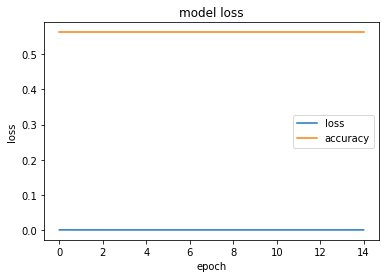

In [39]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'])
plt.show()

In [40]:
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [41]:
# Take last 28 days in the past to predict the next 28 days in the future
test_input = np.array(X_train[:, -timesteps:, :]) # Here timesteps=28
test_input = test_input.reshape((X_train.shape[0], timesteps, num_features)) # Very important to reshape to assure that the test input has the correct shape (# samples, # timesteps, # features)
print(test_input.shape)

# Predict the next 28 days 
y_test = model.predict(test_input[:,-timesteps:, :], verbose=2)

# Concatenate prediction with past timesteps
test_forecast= np.concatenate((test_input[:,:,8].reshape(test_input.shape[0],test_input.shape[1]), 
                           y_test.astype(np.float32).reshape(test_input.shape[0],test_input.shape[1])),axis=1).reshape((test_input.shape[0],test_input.shape[1]+28,1))
print(y_test)
print(test_forecast.shape)

(30490, 28, 9)
953/953 - 14s - 14s/epoch - 15ms/step
[[[0.00317744]
  [0.00371758]
  [0.00405231]
  ...
  [0.00427066]
  [0.00427017]
  [0.00426985]]

 [[0.00231743]
  [0.0022923 ]
  [0.00224831]
  ...
  [0.00215459]
  [0.00215432]
  [0.00215409]]

 [[0.00248961]
  [0.00259134]
  [0.00263461]
  ...
  [0.00258952]
  [0.00258907]
  [0.00258873]]

 ...

 [[0.00335679]
  [0.00400989]
  [0.00442741]
  ...
  [0.0047385 ]
  [0.00473756]
  [0.00473692]]

 [[0.00390265]
  [0.00492844]
  [0.00555588]
  ...
  [0.00593032]
  [0.00592901]
  [0.00592812]]

 [[0.00517448]
  [0.00690864]
  [0.00791279]
  ...
  [0.00815431]
  [0.00815297]
  [0.00815209]]]
(30490, 56, 1)


In [42]:
print(y_test.shape)
print(test_forecast.shape)

(30490, 28, 1)
(30490, 56, 1)


In [43]:
# Reverse normalize to obtain human interpratable values
test_forecast = FNoramlize(test_forecast,train_low,train_high)

# Round values
test_forecast = np.rint(test_forecast)

In [44]:
# Transform into DataFrame and keep only the predictions
forecast = pd.DataFrame(test_forecast.reshape(test_forecast.shape[0],test_forecast.shape[1])).iloc[:,-28:]
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast[forecast < 0] = 0
forecast.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [47]:
train_data = pd.read_csv('/content/drive/MyDrive/m5-forecasting/m5-forecasting-accuracy.zip (Unzipped Files)/sales_train_validation.csv')
validation_ids = train_data['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]

In [48]:
ids = np.concatenate([validation_ids, evaluation_ids])

In [49]:
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast]*2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)

In [50]:
predictions.to_csv('submission.csv', index=False)